This is the project for Coursera course How to Win a Data Science Competition: Learn from Top Kagglers (2019).
Author: Aleksi Heikkilä.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

The competition website at Kaggle: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

Further instructions on the notebook (KaggleProj_Final.ipynb)

    - KaggleProj_Final.ipynb is the all-encompassing jupyter notebook
    - DATA_FOLDER variable in the notebook points the folder where one should put
        - the original data files provided on Kaggle (not included in the zip)
        - the pickle files in the zip
    - The python_relevant_module_versions.txt just lists the dependencies
    - by default the submission files are being written to the present working directory (usually the dir where the notebook is located)


I did not include the data_all_v4.msgpack file that contains the feature engineered dataset.
This is due to its size.
However, the notebook contains the code to re-create it (takes some time though).

The final serialized model lies in '2019-03-16-model-xgb.pickle'
It generated (after the LB probe adjustment) FINAL_SUBMISSION.csv

Requirements:

Python3. The version used was 3.6.3. 

You need the following modules and whatever dependencies they have. The version used (others might be fine as well - no guarantees):
- cufflinks==0.14.6
- hyperopt==0.1.1
- lightgbm==2.2.2
- matplotlib==3.0.2
- numpy==1.14.5
- pandas==0.23.4
- plotly==3.5.0
- scikit-learn==0.20.0
- seaborn==0.9.0
- tqdm==4.28.1
- workdays==1.4
- xgboost==0.7

Amount of RAM can turn out to be a bottleneck. Did this with 32 GB. 16 GB could do as well.

Some computations are quite intense, so having a relatively fast CPU won't hurt.

I also stored some precomputed datafiles / predictions that could be used here and there to go past this issue.


## Imports and defs

In [1]:
# Parameters that affect what code is run and how

# This is the folder where you have the data files. 
# This is also the folder where models and intermediary datafiles are written.
DATA_FOLDER = "PATH_TO_THE_DATA_FOLDER"

RUN_XGB_HYPEROPT = False  # True: run time-consuming hyperparameter search for XGBRegressor using hyperopt

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import os
import gc
import pickle

# Models
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error  # ,make_scorer

# Preproc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm import tqdm_notebook

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from itertools import product

# Plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)

from calendar import monthrange
import workdays
from workdays import networkdays
from datetime import date

# Pandas settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
def root_mean_squared_error(truth, pred):
    return sqrt(mean_squared_error(truth, pred))

def my_mean(x):
    """Function to calculate mean from very large dataset (traditional ways seem to sometimes run into overflow-kind of situations )"""
    return np.average(x, weights=np.ones_like(x) / x.size)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Read in the data

In [5]:
# Items
items = pd.read_csv(os.path.join(DATA_FOLDER, "items.csv"))
print(items.shape)
print(items.sample(5))

# Something could be extracted from the item_name. E.g. some category kind of information. 
# E.g. there could be some cats like "BD" = Blue Ray disk, CD, DVD, PC, PS3... Not used right now.

# No immediate use for the name (although there is some potential value to extract...). Drop now

items = items[["item_id", "item_category_id"]]

(22170, 3)
                                               item_name  item_id  \
15502  Мягкая игрушка-подушка Adventure Time Princess...    15502   
19407  Снайпер. Воин Призрак 2. Специальное издание [...    19407   
15184         Мой аэропорт 2 [PC, Jewel, русская версия]    15184   
11634                                     ЗАРАЖЕНИЕ (BD)    11634   
12496                                    КЛАСС КОРРЕКЦИИ    12496   

       item_category_id  
15502                63  
19407                19  
15184                30  
11634                37  
12496                40  


In [6]:
# item categories
item_cats = pd.read_csv(os.path.join(DATA_FOLDER, "item_categories.csv"))
print(item_cats.shape)
item_cats.head(3)

# There is group-like info in the cat_name. Extract that later

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [7]:
sales_train = pd.read_csv(os.path.join(DATA_FOLDER, "sales_train.csv.gz"))   # this is the original, slow to read...

# Due to occasional kernel restarts when developing, I wrote sales_train as parquet for faster subsequent loading
# sales_train to disk as parquet (DO JUST ONCE):
# sales_train.to_parquet(os.path.join(DATA_FOLDER, "sales_train.parquet"))

# THEN READ FROM HERE:
#sales_train = pd.read_parquet(os.path.join(DATA_FOLDER, "sales_train.parquet"))

# Convert date to datetime format
sales_train["date"] = pd.to_datetime(sales_train["date"], dayfirst=True)
print(sales_train.shape)

# Add revenue column
sales_train["revenue"] = sales_train.item_price * sales_train.item_cnt_day

sales_train.head(3)

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-01-02,0,59,22154,999.0,1.0,999.0
1,2013-01-03,0,25,2552,899.0,1.0,899.0
2,2013-01-05,0,25,2552,899.0,-1.0,-899.0


What is the date_block? This is basically month number, (within train data) starting from Jan 2013 to Oct 2015 (33 pcs).

The train data consists of daily historical transaction data from January 2013 to October 2015. It contains just transactions, so there is only non-zero values (and not "transactions that did not occur")

In [8]:
#.We are asking you to predict total sales for every product and store in the next month.
sales_test = pd.read_csv(os.path.join(DATA_FOLDER, "test.csv.gz"))
#sales_test["date"] = pd.to_datetime(sales_test["date"], dayfirst=True)

# Set the ID as index
sales_test.set_index("ID", inplace=True)

print(sales_test.shape)
sales_test.head(3)

(214200, 2)


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233


We are asked to predict total monthly sales for every product and store (that are in the test data) in the next month.

Month to predict: November 2015.

In [9]:
# Shops
shops = pd.read_csv(os.path.join(DATA_FOLDER, "shops.csv"))
print(shops.shape)
shops.head(3)

# Can we extract something from the shop_name? Yes, there seems to be Russian city in the beginning

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


## Some data inspection, EDA and pre-processing

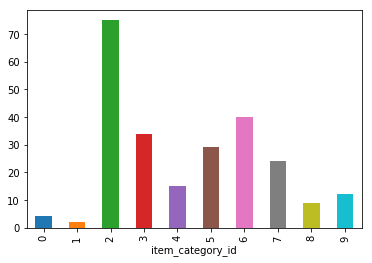

In [10]:
# Quick look at the data
# item ids by category
items.groupby("item_category_id")["item_id"].count().head(10).plot(kind='bar')

The item_category_name contains sort of group and subgroup information that will be extracted.

As a first attempt, I will label encode the new categorical variables. It could be worth to check whether onehot would work better for (some of) them (omitted)

In [11]:
# There seems to be a group in the beginning of the item cat. name
print(item_cats["item_category_name"].str.split("-").head(10))

# extract it to a new column and label encode them
item_cats["item_category_group"] = item_cats["item_category_name"].str.split("-").map(lambda x: x[0].strip())
item_cats["item_category_group_code"] = LabelEncoder().fit_transform(item_cats["item_category_group"])

# the latter part is kind of subgroup, whenever it exists it seems. Extract and label encode
item_cats["item_category_subgroup"] = item_cats["item_category_name"].str.split("-").map(lambda x: x[1].strip() if len(x) > 1 else "MISSING")
item_cats["item_category_subgroup_code"] = LabelEncoder().fit_transform(item_cats["item_category_subgroup"])

# Thanks to e.g. Angshuman Saikia's Kaggle notebook, there are translations (+ groupings) for the categories
# Form the groups and label encode
l_cat = list(item_cats.item_category_name)
l_cat[0] = 'PC Headsets'
for ind in range(1,8):
    l_cat[ind] = 'Accessories'  
l_cat[8] = 'Tickets'  
l_cat[9] = 'Goods'    
for ind in range(10,18):
    l_cat[ind] = 'Game consoles'
for ind in range(18,32):
    l_cat[ind] = 'Games'
for ind in range(32,37):
    l_cat[ind] = 'Payment cards'
for ind in range(37,43):
    l_cat[ind] = 'Movie'
for ind in range(43,55):
    l_cat[ind] = 'Books'
for ind in range(55,61):
    l_cat[ind] = 'Music'
for ind in range(61,73):
    l_cat[ind] = 'Presents'
for ind in range(73,79):
    l_cat[ind] = 'Programs'
l_cat[79] = 'Service'  
l_cat[80] = 'Service'
l_cat[81] = 'Clean media'  
l_cat[82] = 'Clean media'
l_cat[83] = 'Batteries' 

item_cats['item_category_group2'] = l_cat
item_cats['item_category_group2_code'] = LabelEncoder().fit_transform(item_cats["item_category_group2"])

print("\nAfter extracting the preceding item group:")
print(item_cats.sample(10))

# Keep only the cat id and the codes
item_cats = item_cats[["item_category_id", "item_category_group_code", "item_category_subgroup_code", "item_category_group2_code"]]

# Merge this stuff to items. We will use only this items dataframe later
items = items.merge(item_cats, on="item_category_id", how="left")

# Optimize data types
items["item_category_id"] = items["item_category_id"].astype(np.int8)
items["item_category_group_code"] = items["item_category_group_code"].astype(np.int8)
items["item_category_group2_code"] = items["item_category_group2_code"].astype(np.int8)
items["item_category_subgroup_code"] = items["item_category_subgroup_code"].astype(np.int8)
items["item_id"] = items["item_id"].astype(np.int16)

0    [PC ,  Гарнитуры/Наушники]
1           [Аксессуары ,  PS2]
2           [Аксессуары ,  PS3]
3           [Аксессуары ,  PS4]
4           [Аксессуары ,  PSP]
5        [Аксессуары ,  PSVita]
6      [Аксессуары ,  XBOX 360]
7      [Аксессуары ,  XBOX ONE]
8              [Билеты (Цифра)]
9             [Доставка товара]
Name: item_category_name, dtype: object

After extracting the preceding item group:
                 item_category_name  item_category_id  \
23                  Игры - XBOX 360                23   
7             Аксессуары - XBOX ONE                 7   
81          Чистые носители (шпиль)                81   
3                  Аксессуары - PS4                 3   
44       Книги - Аудиокниги (Цифра)                44   
29  Игры PC - Коллекционные издания                29   
6             Аксессуары - XBOX 360                 6   
45            Книги - Аудиокниги 1С                45   
25        Игры - Аксессуары для игр                25   
36   Карты оплаты - Window

In [12]:
print("So we get items representation like this:")
items.head(5)

So we get items representation like this:


,item_id,item_category_id,item_category_group_code,item_category_subgroup_code,item_category_group2_code
0,0,40,11,4,7
1,1,76,15,31,12
2,2,40,11,4,7
3,3,40,11,4,7
4,4,40,11,4,7


The shop name contains city in Russia. Extract and label encode:

In [13]:
# The first part in the beginning seems to be a city in Russia. Let's extract that
shops["shop_city"] = shops["shop_name"].map(lambda x: x.split()[0].strip())
shops.sample(10)

,shop_name,shop_id,shop_city
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
34,"Н.Новгород ТРЦ ""РИО""",34,Н.Новгород
29,"Москва ТЦ ""Новый век"" (Новокосино)",29,Москва
56,"Чехов ТРЦ ""Карнавал""",56,Чехов
51,"Тюмень ТЦ ""Зеленый Берег""",51,Тюмень
53,"Уфа ТЦ ""Семья"" 2",53,Уфа
19,"Курск ТЦ ""Пушкинский""",19,Курск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
21,"Москва МТРЦ ""Афи Молл""",21,Москва
30,"Москва ТЦ ""Перловский""",30,Москва


Correct the misspelling and label-encode the city:

In [14]:
# Check if there are typos etc
print(sorted(shops.shop_city.unique()))  # Yep, one seems to be duplicated: !Якутск and Якутск. Correct this:
shops.loc[shops["shop_city"] == "!Якутск", "shop_city"] = "Якутск"
print("\n\nShops per city:")
print(shops.shop_city.value_counts())

# Then label encode the city, and then keep only the id and the city. Wont be using the shop name
shops["shop_city_code"] = LabelEncoder().fit_transform(shops["shop_city"]).astype(np.int8)
shops = shops[["shop_id", "shop_city_code"]]

['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж', 'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга', 'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород', 'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев', 'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов', 'Якутск', 'Ярославль']


Shops per city:
Москва              13
Якутск               4
Тюмень               3
Воронеж              3
РостовНаДону         3
СПб                  2
Жуковский            2
Самара               2
Уфа                  2
Красноярск           2
Новосибирск          2
Н.Новгород           2
Казань               2
Интернет-магазин     1
Цифровой             1
Коломна              1
Выездная             1
Сергиев              1
Адыгея               1
Химки                1
Томск                1
Чехов                1
Вологда              1
Мытищи               1
Сургут               1
Балашиха             1
Омск                 1
Калу

Careful inspection of the shop names indicates that there are three shops that seems to appear on two ids each. Correct this in the train and test data by homogenizing the ids.

Shops seem to have duplicates (a little bit different shop names that seem to refer to the same thing)
- Seems that shop_id 0 <=> 57
- Seems that shop_id 1 <=> 58
- Seems that shop_id 10 <=> 11

Lets use the latter ids.


In [15]:
# Standardize these. Within train and test:
# Якутск Орджоникидзе, 56. Lets use id 57
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_test.loc[sales_test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный". Lets use id 58
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
sales_test.loc[sales_test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м². Lets use id 11
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
sales_test.loc[sales_test.shop_id == 10, 'shop_id'] = 11

# One could also drop the duplicates from the shops, but those duplicates will no longer get joined into the other data and should be harmless.

Duplicated rows? Get rid of the duplicates:

In [16]:
# Are there duplicated rows?
print(f"sales_train: There are {np.sum(sales_train.duplicated())} duplicated rows")
print(f"sales_test: There are {np.sum(sales_test.duplicated())} duplicated rows")
print(f"shops: There are {np.sum(shops.duplicated())} duplicated rows")
print(f"items: There are {np.sum(items.duplicated())} duplicated rows")
print(f"item_cats: There are {np.sum(item_cats.duplicated())} duplicated rows")

# yep, get rid of these
print("Shape of sales_train before: ", sales_train.shape)
sales_train = sales_train.loc[~sales_train.duplicated(keep='first')]
print("Shape of sales_train after: ", sales_train.shape)

sales_train: There are 6 duplicated rows
sales_test: There are 0 duplicated rows
shops: There are 0 duplicated rows
items: There are 0 duplicated rows
item_cats: There are 0 duplicated rows
Shape of sales_train before:  (2935849, 7)
Shape of sales_train after:  (2935843, 7)


Check the data for abnormalities:

In [175]:
# Basic stats from the sales_train
sales_train.describe()
# Some abnormalities: negative item price(s),
# Neg. item counts ok. Those are returns
# Some quite large item counts and prices. Check these further

,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
count,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06,2.935843e+06
mean,1.456991e+01,3.331062e+01,1.019723e+04,8.908535e+02,1.242641e+00,1.157733e+03
std,9.422992e+00,1.613680e+01,6.324293e+03,1.729801e+03,2.618837e+00,5.683609e+03
min,0.000000e+00,2.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,-6.897000e+04
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.490000e+02
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.490000e+02
75%,2.300000e+01,4.800000e+01,1.568400e+04,9.990000e+02,1.000000e+00,1.078200e+03
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,1.829990e+06


In [17]:
# There is a single item_price that is negative. 
# Could mean returned item? Or not...
# Lets impute the price for the median of the valid prices of that month, item, shop
# Adjust the revenue accordingly
print(sales_train.loc[sales_train.item_price < 0])

imp_median = sales_train[(sales_train.shop_id == 32) & (sales_train.item_id == 2973) \
                   & (sales_train.date_block_num == 4) & (sales_train.item_price > 0)].item_price.median()

sales_train.loc[sales_train.item_price < 0, 'revenue'] = imp_median  # the item count was 1
sales_train.loc[sales_train.item_price < 0, 'item_price'] = imp_median

             date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
484683 2013-05-15               4       32     2973        -1.0           1.0   

        revenue  
484683     -1.0  


Further checks:
- all the item_cnt_day are integers (there are no decimal parts other than zero)

Lets check then the item price and quantity outliers:

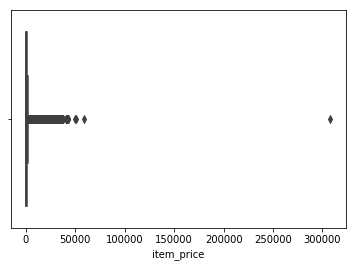

In [18]:
sns.boxplot(x=sales_train.item_price)  # at least one outlier, it seems

In [19]:
# Let's filter out at least that one extreme value
print("Shape of sales_train before: ", sales_train.shape)
sales_train = sales_train.loc[sales_train.item_price < 150000]
print("Shape of sales_train after: ", sales_train.shape)

Shape of sales_train before:  (2935843, 7)
Shape of sales_train after:  (2935842, 7)


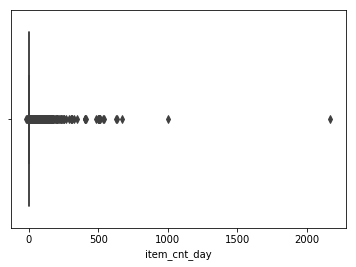

In [179]:
sns.boxplot(x=sales_train.item_cnt_day)  # some relatively high values...

In [20]:
# Let's filter out extreme values. I ended up considering values 1000+ as outliers (of course this is just an assumption - we don't know)
print("Shape of sales_train before: ", sales_train.shape)
sales_train = sales_train.loc[sales_train.item_cnt_day <= 1000]
print("Shape of sales_train after: ", sales_train.shape)

Shape of sales_train before:  (2935842, 7)
Shape of sales_train after:  (2935841, 7)


In [181]:
# Quick look again at the basic stats of the data
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
count,2.935841e+06,2.935841e+06,2.935841e+06,2.935841e+06,2.935841e+06,2.935841e+06
mean,1.456991e+01,3.331063e+01,1.019723e+04,8.907498e+02,1.241903e+00,1.157629e+03
std,9.422989e+00,1.613679e+01,6.324294e+03,1.720492e+03,2.292965e+00,5.680790e+03
min,0.000000e+00,2.000000e+00,0.000000e+00,7.000000e-02,-2.200000e+01,-6.897000e+04
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.490000e+02
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.490000e+02
75%,2.300000e+01,4.800000e+01,1.568400e+04,9.990000e+02,1.000000e+00,1.078200e+03
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,1.000000e+03,1.829990e+06


In [182]:
# Stats of the dates for train dataset
sales_train.date.describe()  # Then forecast 11/2015

count                 2935841
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

### A bit more EDA

There is a decreasing trend ite items sold over time, with some clear seasonality

In [183]:
# Lets check how the time trends are
sales_train_month = sales_train[["date", "item_cnt_day"]].resample("M", on="date").sum()

# Create a trace
trace = go.Scatter(
    x = sales_train_month.index,
    y = sales_train_month.item_cnt_day,
    name="unclipped"
)

data = [trace]
iplot(data, filename='basic-line')


Check the seasonality patterns:

December stands out (note though that the Nov, Dec values are means that does not contain the year 2015: There might seems higher than they are as the general trend has been declining

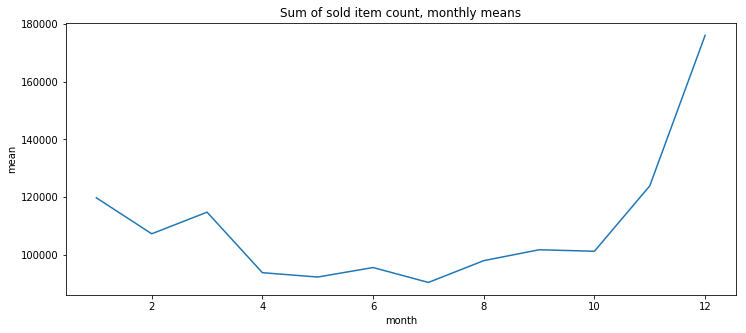

In [184]:
sales_train_month2 = sales_train_month.reset_index().rename(columns={"item_cnt_day": "item_cnt_month"})
sales_train_month2["month"] = sales_train_month2["date"].dt.month
sales_train_month2.drop(columns="date", inplace=True)
sales_train_monthly = sales_train_month2.groupby("month").agg({"item_cnt_month": [sum, np.mean]})
sales_train_monthly.columns = sales_train_monthly.columns.droplevel()
sales_train_monthly = sales_train_monthly.reset_index()

f, axes = plt.subplots(1, 1, figsize=(12, 5))
sns.lineplot(x="month", y="mean", data=sales_train_monthly, ax=axes).set_title("Sum of sold item count, monthly means")
plt.show()

In [185]:
# There are no zero count transactions...
sum(sales_train["item_cnt_day"] == 0)

0

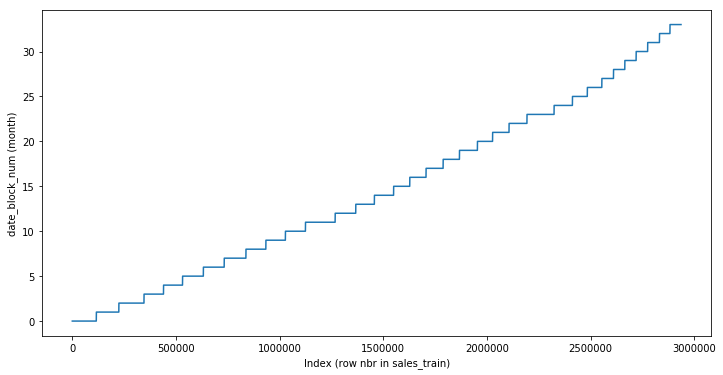

In [186]:
plt.figure(figsize=(12,6))
sales_train.date_block_num.plot()
plt.xlabel("Index (row nbr in sales_train)"); plt.ylabel("date_block_num (month)");

# The data seems to be ordered by time (at least month). The data is relatively balanced when it comes to months

Next, study the train and test set. Their differences and how the test set was probably created.

Conclusions from the above cells:
- There are some never-seen-before products in the test set. There could be something to be gained if these are handled more wisely.
- Train set is just the transactions as they occured
- Test set seems to be a cartesian product of some subset of shops and items. 
    - I guess it has been formed by taking sets of those shops and items that actually had transactions in the test set (Nov 2015), and forming the complete cartesian product from these
    - This also means that most of the item_counts in test would be zeros
    - We need to create a training dataset that is similar, i.e. contains those zeros as well.
    - One approach I tried but which did not help in my case: use only those shops and items that are in test data for training.



In [187]:
# Are there never seen products / shops in test?
train_shopids = set(sales_train.shop_id)
train_prodids = set(sales_train.item_id)

test_shopids = set(sales_test.shop_id)
test_prodids = set(sales_test.item_id)

# new shops
print("New shop_ids: ", test_shopids.difference(train_shopids)) # no totally new shops...
print("No totally new shops in test data!")

print(f"\nThere are {len(test_prodids.difference(train_prodids))} item_ids in test set that were not seen in train data! The following ids:")
print("\nnew prodids in test set: ", test_prodids.difference(train_prodids))  # zeros were not in the train set, so that's that
# So these may not be "new", but never-sold ones

# Hence we predict every item (in test set) for every shop for the one month
# The result should be mostly zeros

New shop_ids:  set()
No totally new shops in test data!

There are 363 item_ids in test set that were not seen in train data! The following ids:

new prodids in test set:  {20486, 6152, 6153, 6169, 14383, 20535, 4156, 10310, 20560, 20561, 83, 20577, 16498, 20594, 6259, 20599, 20600, 12409, 18560, 10372, 140, 8337, 12441, 8354, 8355, 168, 173, 12468, 12469, 12470, 12471, 14521, 6335, 18627, 20677, 20680, 204, 4310, 16601, 4318, 237, 10483, 249, 254, 10507, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 12568, 20760, 12574, 16675, 6439, 302, 12591, 14647, 14648, 4412, 20796, 14662, 8545, 20836, 8549, 20837, 8551, 20843, 20845, 2420, 6519, 6520, 6521, 2426, 2427, 2428, 6522, 6523, 20863, 6524, 6525, 2434, 6531, 6526, 6527, 6528, 6529, 6530, 6532, 6533, 20878, 20879, 20880, 402, 14739, 14760, 16811, 428, 16813, 430, 14765, 14784, 454, 480, 18913, 8676, 14832, 6645, 10747, 12802, 20996, 2569, 8722, 10779, 4642, 18979, 566, 8760, 6729, 6730, 6731, 6732, 6733, 6734, 16976, 6742, 6743, 12890, 19048

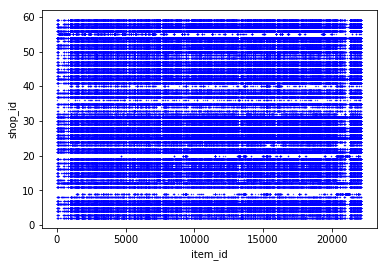

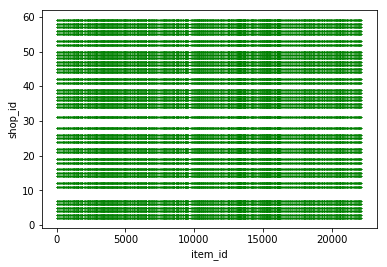

In [188]:
# The sales_train is the actual transactions. 
sales_train.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='Blue', s = 0.1)

# The test set seems to be cartesian product of shops and items (this ordered structure...)
sales_test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='Green', s = 0.1)

### Naive baseline: pred prev month values

This code is not part of the final solution. 

- Simply using previous month's actual values as predictions --> public LB score of 1.16777.
- Then adjusting it by the number of days per month (Oct: 31 days, Nov: 30 days) improved the naive model slightly --> public LB score on Kaggle platform 1.16519. 


## Data/feature preprocessing

#### Generate calendar info about the months

Generate features days_per_month, weekdays_per_month, workdays_per_month (taking into account public holidays that land on weekdays...)

In [189]:
years_list = [2013] * 12 + [2014] * 12 + [2015] * 11
months_list = list(range(1,13)) * 2 + list(range(1,12))

days_per_month_mapping = {}
weekdays_per_month_mapping = {}  # this excludes just weekends
# create a dictionary that gives the number of days per date_month_id
for i,(y,m) in enumerate(zip(years_list, months_list)):
    days_per_month_mapping[i] = monthrange(y, m)[1]
    weekdays_per_month_mapping[i] = networkdays(date(y,m,1), date(y,m,monthrange(y, m)[1]))

# train: Daily historical data from January 2013 (date_block_id = 0) to October 2015 (date_block_id = 33) 
# test: November 2015  (date_block_id = 34) 

del years_list, months_list

# Then generate dict for the number of working days per months
# i.e. nbr of weekdays minus public holidays that fall on weekdays (source: https://www.officeholidays.com/countries/russia/2015.php)
# Adjust those months that needs it
workdays_per_month_mapping = weekdays_per_month_mapping.copy()

workdays_per_month_mapping[0] = workdays_per_month_mapping[0] - 6
workdays_per_month_mapping[2] = workdays_per_month_mapping[2] - 1   # March 2013
workdays_per_month_mapping[4] = workdays_per_month_mapping[4] - 5   # May 2013
workdays_per_month_mapping[5] = workdays_per_month_mapping[5] - 1   # June 2013
workdays_per_month_mapping[10] = workdays_per_month_mapping[10] - 1 # Nov 2013

workdays_per_month_mapping[12] = workdays_per_month_mapping[12] - 6 # Jan 2014
workdays_per_month_mapping[14] = workdays_per_month_mapping[14] - 1 # Mar 2014
workdays_per_month_mapping[16] = workdays_per_month_mapping[16] - 3 # May 2014
workdays_per_month_mapping[17] = workdays_per_month_mapping[17] - 2 # Jun 2014
workdays_per_month_mapping[22] = workdays_per_month_mapping[22] - 2 # Nov 2014

workdays_per_month_mapping[24] = workdays_per_month_mapping[24] - 7 # Jan 2015
workdays_per_month_mapping[25] = workdays_per_month_mapping[25] - 1 # Feb 2015
workdays_per_month_mapping[26] = workdays_per_month_mapping[26] - 1 # Mar 2015
workdays_per_month_mapping[28] = workdays_per_month_mapping[28] - 3 # May 2015
workdays_per_month_mapping[29] = workdays_per_month_mapping[29] - 1 # Jun 2015

workdays_per_month_mapping[34] = workdays_per_month_mapping[34] - 1 # Nov 2015

### Price statistics

Features to indicate price changes within a month, for shop-item pairs:

In [190]:
# Consider only items sold (not returns)
# Per item-shop, when does the item_price change and how? Agg to month level. Take absolute and relative deltas
pricedelta_month_shop_item_date = sales_train.loc[sales_train.item_cnt_day > 0].sort_values(["item_id", "shop_id", "date"], ascending=True)
pricedelta_month_shop_item_date["shop_item_price_diff"] = pricedelta_month_shop_item_date["item_price"].diff()
pricedelta_month_shop_item_date["shop_item_price_prev_value"] = pricedelta_month_shop_item_date["item_price"].shift(1)

# Apply mask for the borders:
pricedelta_month_shop_item_date.loc[(pricedelta_month_shop_item_date["shop_id"] != pricedelta_month_shop_item_date["shop_id"].shift(1)) | \
                                    (pricedelta_month_shop_item_date["item_id"] != pricedelta_month_shop_item_date["item_id"].shift(1)), \
                                    ["shop_item_price_diff", "shop_item_price_prev_value"]] = np.nan

pricedelta_month_shop_item_date["shop_item_price_diff_perc"] = pricedelta_month_shop_item_date["shop_item_price_diff"] \
                                                                / pricedelta_month_shop_item_date["shop_item_price_prev_value"]

# Aggregate. Sum of price changes for item-shop within a month. And the first previous value
pricedelta_month_shop_item = pricedelta_month_shop_item_date.groupby(["date_block_num", "shop_id", "item_id"]).agg({"shop_item_price_diff": sum, \
                                                                                             "shop_item_price_prev_value": 'first'})

pricedelta_month_shop_item["shop_item_price_diff_perc"] = pricedelta_month_shop_item["shop_item_price_diff"] \
                                                            / pricedelta_month_shop_item["shop_item_price_prev_value"]

pricedelta_month_shop_item = pricedelta_month_shop_item[["shop_item_price_diff", "shop_item_price_diff_perc"]]
pricedelta_month_shop_item = pricedelta_month_shop_item.fillna(0).reset_index()   # fillna 0: "no change"

Price statistics for a) month-shop-item triplets and b) month-item pairs: 

min, max, mean item_price, and how many unique dates when the item was sold:

In [191]:
# Consider actual sales, Price statistics for there
# min, mean, max item price per... and on how many different days was there sales per...
price_stats_month_shop_item = sales_train.loc[sales_train.item_cnt_day > 0] \
                            .groupby(["date_block_num", "shop_id", "item_id"]) \
                            .agg({"item_price": [np.min, np.max, np.mean], \
                                 "date": pd.Series.nunique})

price_stats_month_item = sales_train.loc[sales_train.item_cnt_day > 0] \
                            .groupby(["date_block_num", "item_id"]) \
                            .agg({"item_price": [np.min, np.max, np.mean], \
                                 "date": pd.Series.nunique})

price_stats_month_shop_item.columns = price_stats_month_shop_item.columns.droplevel()
price_stats_month_shop_item = price_stats_month_shop_item.reset_index()

price_stats_month_item.columns = price_stats_month_item.columns.droplevel()
price_stats_month_item = price_stats_month_item.reset_index()

price_stats_month_shop_item.rename(columns={"amin": "month_shop_item_min_price", "amax": "month_shop_item_max_price", \
                                            "mean": "month_shop_item_avg_price", "nunique": "month_shop_item_saledays"}, inplace=True)

price_stats_month_item.rename(columns={"amin": "month_item_min_price", "amax": "month_item_max_price", \
                                       "mean": "month_item_avg_price", "nunique": "month_item_saledays"}, inplace=True)

In [192]:
price_stats_month_shop_item.sample(5)

,date_block_num,shop_id,item_id,month_shop_item_min_price,month_shop_item_max_price,month_shop_item_avg_price,month_shop_item_saledays
567820,9,58,5637,2590.0,2590.0,2590.000,2
1339495,25,57,1555,1799.0,1799.0,1799.000,3
589919,10,27,15020,149.0,149.0,149.000,1
1231710,23,41,3710,799.0,799.0,799.000,1
1336199,25,54,4240,499.5,999.0,774.245,4


#### Build the grid and join stuff

To replicate the structure that the test dataset seems to have, create a grid (cartesian product) of monthly shop_id, item_id combinations (as observed for that month).

This is to make sure we have the zero item counts in our training data (to begin with, it contains only those non-zero sales transactions)


In [193]:
grid = []
index_cols = ["shop_id", "item_id", "date_block_num"]

# for every training month, determine what shop_ids and item_ids are present in the data
for date_block_num in sales_train["date_block_num"].unique():
    shops_month = sales_train.loc[sales_train["date_block_num"] == date_block_num, "shop_id"].unique()
    items_month = sales_train.loc[sales_train["date_block_num"] == date_block_num, "item_id"].unique()
    
    grid.append(np.array(list(product(*[shops_month, items_month, [date_block_num]])),dtype='int16'))

# now the grid is a list of monthly numpy arrays, each with quite a lot of rows and those three values, shop, item, block
# Convert this to pandas dataframe by vertically stacking those arrays on top of each other   
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int16)
grid["shop_id"] = grid["shop_id"].astype(np.int8)
grid["date_block_num"] = grid["date_block_num"].astype(np.int8)


In [194]:
#grid.describe()
# dtype optimization:
# max shopid 59 <-> np.int8 (-128 to 127)
# max itemid 22169 <-> np.int16
# date_block_sum <-> np.int8

Create some aggregate values:

In [195]:
index_cols = ["shop_id", "item_id", "date_block_num"]
# Groupby data to get shop-item-month aggregates

gb = sales_train.groupby(index_cols).agg({'item_cnt_day': 'sum', "item_price": np.mean})
gb.columns = ["target", "month_shop_item_avg_price"]  # lets call this shop-item-month sum of item_cnt_day as target (which it is)
gb.reset_index(inplace=True)

train = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Clip the target (already filled missing values with zeros). Then it will fit to int8
#  There has been discussions in the Kaggle forum that it would be better to clip this to 0,40 or so. And then just clip the end results
# One could try both. I will no stick to this approach.
train["target"] = train["target"].clip(0,40).astype(np.float16)  # float will behave better with NaNs
 
# Downcast dtypes from 64 to 32 bit to save memory
train = downcast_dtypes(train)

del gb, grid
gc.collect();

# # Now target = the item_count for that shop, item, month (the actual target)

In [196]:
train.describe()   # calculating mean just fails for this large dataset...

,shop_id,item_id,date_block_num,target,month_shop_item_avg_price
count,1.091380e+07,1.091380e+07,1.091380e+07,10913804.0,1.091380e+07
mean,3.137817e+01,1.130929e+04,1.497336e+01,NaN,1.164943e+02
std,1.730214e+01,6.209982e+03,9.495635e+00,0.0,6.434461e+02
min,2.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
25%,1.600000e+01,5.976000e+03,7.000000e+00,0.0,0.000000e+00
50%,3.000000e+01,1.139100e+04,1.400000e+01,0.0,0.000000e+00
75%,4.700000e+01,1.660500e+04,2.300000e+01,0.0,0.000000e+00
max,5.900000e+01,2.216900e+04,3.300000e+01,40.0,5.099900e+04


In [197]:
# Process the test data so that it can be combined for train for further feature engineering
# Do the dtype optimization for test as well

sales_test['date_block_num'] = 34  #  Add this because we merge train and test temporarily together (Train end at 33.)
sales_test['date_block_num'] = sales_test['date_block_num'].astype(np.int8)  # dtype optimization
sales_test['shop_id'] = sales_test['shop_id'].astype(np.int8)
sales_test['item_id'] = sales_test['item_id'].astype(np.int16)
#sales_test['ID'] = sales_test['ID'].astype(np.int32)

sales_test.info()
sales_test.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 3 columns):
shop_id           214200 non-null int8
item_id           214200 non-null int16
date_block_num    214200 non-null int8
dtypes: int16(1), int8(2)
memory usage: 2.5 MB


,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


#### Combine train and test and join common stuff

In [198]:
index_cols = ["shop_id", "item_id", "date_block_num"]
data_all = pd.concat([train, sales_test], sort=False, ignore_index=True, keys=index_cols).fillna(0)  # fill zero values (for the test part in practice)

#del sales_train  # used later
# del train
# need sales_test later

# Then join stuff
# Add item category and subcategory codes
data_all = data_all.merge(items, on="item_id", how="left")

# Add shop's city code
data_all = data_all.merge(shops, on="shop_id", how="left")

# Then add calendar info
data_all["days_per_month"] = data_all["date_block_num"].map(days_per_month_mapping).astype(np.int8)
data_all["weekdays_per_month"] = data_all["date_block_num"].map(weekdays_per_month_mapping).astype(np.int8)
data_all["workdays_per_month"] = data_all["date_block_num"].map(workdays_per_month_mapping).astype(np.int8)

# Add feature for "month of year"
data_all["month"] = data_all["date_block_num"] % 12  # 0 Jan, 1 Feb, ...

gc.collect()

data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 14 columns):
shop_id                        int8
item_id                        int16
date_block_num                 int8
target                         float16
month_shop_item_avg_price      float32
item_category_id               int8
item_category_group_code       int8
item_category_subgroup_code    int8
item_category_group2_code      int8
shop_city_code                 int8
days_per_month                 int8
weekdays_per_month             int8
workdays_per_month             int8
month                          int8
dtypes: float16(1), float32(1), int16(1), int8(11)
memory usage: 286.5 MB


In [199]:
data_all.sample(5)

,shop_id,item_id,date_block_num,target,month_shop_item_avg_price,item_category_id,item_category_group_code,item_category_subgroup_code,item_category_group2_code,shop_city_code,days_per_month,weekdays_per_month,workdays_per_month,month
1259386,4,17240,3,0.0,0.0,40,11,4,7,2,30,22,22,3
8178040,49,9929,23,0.0,0.0,40,11,4,7,24,31,23,23,11
8569179,45,21677,24,0.0,0.0,40,11,4,7,20,31,22,15,0
6441482,44,18338,17,0.0,0.0,57,13,9,8,20,30,21,19,5
10502812,44,10387,32,0.0,0.0,40,11,4,7,20,30,22,22,8


#### Lag features

We have to respect time and cannot use same month sales data (we would not have any of that for test...). So add lagged features.

In [200]:
# Function to get the lag feats
def lag_features(df, lags, cols, left_df=None, on=['date_block_num', 'shop_id', 'item_id']):
    if isinstance(cols, str):
        cols = [cols] # else list
    
    if left_df is None:
        left_df = df[on + cols]
    else:
        left_df = left_df[on + cols]
        
    for i in lags:
        shifted = left_df.copy()
        shifted.columns = on + [col + '_lag_' + str(i) for col in cols]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=on, how='left')

    return df

In [201]:
lags = [1,2 ,3 ,4, 5, 6, 9, 12]  # what lags (how many months to lag... ) to take

# lag the target
data_all = lag_features(data_all, lags, 'target').fillna(0)  
# this produces nulls: some products / items are missing in some months... in the end, impute with 0s

In [202]:
data_all.sample(5)

,shop_id,item_id,date_block_num,target,month_shop_item_avg_price,item_category_id,item_category_group_code,item_category_subgroup_code,item_category_group2_code,shop_city_code,days_per_month,weekdays_per_month,workdays_per_month,month,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_9,target_lag_12
1698421,50,6457,4,10.0,1199.0,30,8,52,5,24,31,23,18,4,9.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0
10047947,3,4394,30,0.0,0.0,19,5,11,5,1,31,23,23,6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
9881827,21,15151,29,0.0,0.0,43,12,22,2,13,30,22,21,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1633230,46,12249,4,0.0,0.0,40,11,4,7,21,31,23,18,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3336424,59,4701,8,0.0,0.0,57,13,9,8,30,30,21,21,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [203]:
# Add monthly aggs for shops and items, respectively. And lag these

gb = data_all.groupby(['shop_id', 'date_block_num']).agg({'target': "sum"})  # target_shop
gb.columns = ["target_shop"]
gb.reset_index(inplace=True)

data_all = lag_features(data_all, lags, ['target_shop'], left_df=gb, on=['shop_id', 'date_block_num']).fillna(0)


# Same as above but with item-month aggregates
gb = data_all.groupby(['item_id', 'date_block_num']).agg({'target': 'sum'})
gb.columns = ["target_item"]
gb.reset_index(inplace=True)

data_all = lag_features(data_all, lags, ['target_item'], left_df=gb, on=['item_id', 'date_block_num']).fillna(0)

# Tässä keskihinnat tulee siten, että nollat tulee mukaan laskuihin... ei keskimääräinen myyntihinta varsinaisesti

data_all = lag_features(data_all, [1,2], ["month_shop_item_avg_price", "month_shop_item_saledays"], left_df=price_stats_month_shop_item).fillna(-1)
data_all = lag_features(data_all, [1,2], ["month_item_avg_price", "month_item_saledays"], left_df=price_stats_month_item, on=["date_block_num", "item_id"]).fillna(-1)
data_all = lag_features(data_all, [1,2], ["shop_item_price_diff", "shop_item_price_diff_perc"], left_df=pricedelta_month_shop_item).fillna(0)

del gb
gc.collect()

# Add some "interactions": item price in this shop relative to the overall mean price for that item
data_all["month_shop_item_avg_price_to_overall_item_avg_price_lag_1"] = data_all["month_shop_item_avg_price_lag_1"] / data_all["month_item_avg_price_lag_1"]
data_all.loc[data_all["month_shop_item_avg_price_lag_1"] == -1, "month_shop_item_avg_price_to_overall_item_avg_price_lag_1"] = -1

data_all["month_shop_item_avg_price_to_overall_item_avg_price_lag_2"] = data_all["month_shop_item_avg_price_lag_2"] / data_all["month_item_avg_price_lag_2"]
data_all.loc[data_all["month_shop_item_avg_price_lag_2"] == -1, "month_shop_item_avg_price_to_overall_item_avg_price_lag_2"] = -1

data_all = downcast_dtypes(data_all)

In [204]:
data_all.sample(5)

,shop_id,item_id,date_block_num,target,month_shop_item_avg_price,item_category_id,item_category_group_code,item_category_subgroup_code,item_category_group2_code,shop_city_code,days_per_month,weekdays_per_month,workdays_per_month,month,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_9,target_lag_12,target_shop_lag_1,target_shop_lag_2,target_shop_lag_3,target_shop_lag_4,target_shop_lag_5,target_shop_lag_6,target_shop_lag_9,target_shop_lag_12,target_item_lag_1,target_item_lag_2,target_item_lag_3,target_item_lag_4,target_item_lag_5,target_item_lag_6,target_item_lag_9,target_item_lag_12,month_shop_item_avg_price_lag_1,month_shop_item_saledays_lag_1,month_shop_item_avg_price_lag_2,month_shop_item_saledays_lag_2,month_item_avg_price_lag_1,month_item_saledays_lag_1,month_item_avg_price_lag_2,month_item_saledays_lag_2,shop_item_price_diff_lag_1,shop_item_price_diff_perc_lag_1,shop_item_price_diff_lag_2,shop_item_price_diff_perc_lag_2,month_shop_item_avg_price_to_overall_item_avg_price_lag_1,month_shop_item_avg_price_to_overall_item_avg_price_lag_2
2759676,53,3797,7,0.0,0.0,58,13,27,8,25,31,22,22,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1904.0,2030.0,1671.0,1515.0,2332.0,1909.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0,0.0,0.0,0.0,0.0,-1.000000,-1.000000
8911114,14,12536,25,0.0,0.0,55,13,2,8,8,28,20,19,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1172.0,1749.0,1448.0,1111.0,1187.0,1194.0,1253.0,1383.0,10.0,17.0,10.0,9.0,7.0,21.0,11.0,22.0,-1.0,-1.0,-1.0,-1.0,199.000000,9.0,199.000000,13.0,0.0,0.0,0.0,0.0,-1.000000,-1.000000
6745571,4,6687,18,1.0,599.0,30,8,52,5,2,31,23,23,6,1.0,3.0,2.0,7.0,0.0,0.0,0.0,0.0,1159.0,1171.0,1051.0,1229.0,1271.0,1378.0,1460.0,1381.0,58.0,95.0,175.0,714.0,0.0,0.0,0.0,0.0,599.0,1.0,599.0,3.0,589.292847,24.0,586.460999,30.0,0.0,0.0,0.0,0.0,1.016473,1.021381
503153,15,9351,1,0.0,0.0,70,14,54,11,9,28,20,20,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2710.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.0,0.0,0.0,0.0,0.0,-1.000000,-1.000000
8649720,33,16234,24,0.0,0.0,65,14,41,11,14,31,22,15,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1014.0,797.0,597.0,588.0,125.0,0.0,0.0,0.0,34.0,13.0,11.0,17.0,17.0,22.0,26.0,37.0,-1.0,-1.0,-1.0,-1.0,399.000000,18.0,399.000000,11.0,0.0,0.0,0.0,0.0,-1.000000,-1.000000


#### Mean encodings

Add mean (target) encodings for various aggregation combination. And add some item_price statistics at the same time as well.

Lag all of these. For most of these get only the first lag. The lag amount could be further optimized (it would just take some time...)

In [205]:
# target = item_cnt_month
# mean target value per month
grp = data_all.groupby(['date_block_num']).agg({'target': 'mean'})
grp.columns = ['month_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, [1], "month_avg_item_cnt", left_df=grp, on=["date_block_num"]).fillna(0)

In [206]:
# mean target value per month-item
grp = data_all.groupby(['date_block_num', 'item_id']).agg({'target': 'mean'})
grp.columns = ['month_item_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, lags, "month_item_avg_item_cnt", left_df=grp, on=['date_block_num', 'item_id']).fillna(0)

In [207]:
# mean target value per month-shop
grp = data_all.groupby(['date_block_num', 'shop_id']).agg({'target': 'mean'})
grp.columns = ['month_shop_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, lags, "month_shop_avg_item_cnt", left_df=grp, on=['date_block_num', 'shop_id']).fillna(0)

In [208]:
# mean target value per month-item category
grp = data_all.groupby(['date_block_num', 'item_category_id']).agg({'target': 'mean', "month_shop_item_avg_price": np.mean})
grp.columns = ['month_itemcat_avg_item_cnt', 'month_itemcat_avg_item_price']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, [1], ['month_itemcat_avg_item_cnt', 'month_itemcat_avg_item_price'], \
                        left_df=grp, on=['date_block_num', 'item_category_id']).fillna(0)

In [209]:
# mean target value per month-shop-item category
grp = data_all.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'target': 'mean'})
grp.columns = ['month_shop_itemcat_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, [1], "month_shop_itemcat_avg_item_cnt", left_df=grp, on=['date_block_num', 'shop_id', 'item_category_id']).fillna(0)

In [210]:
# mean target value per month-item category group
grp = data_all.groupby(['date_block_num', 'item_category_group_code']).agg({'target': 'mean'})
grp.columns = ['month_itemcatgrp_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, [1], "month_itemcatgrp_avg_item_cnt", left_df=grp, on=['date_block_num', 'item_category_group_code']).fillna(0)

In [211]:
# mean target value per month-item category subgroup
grp = data_all.groupby(['date_block_num', 'item_category_subgroup_code']).agg({'target': 'mean'})
grp.columns = ['month_itemcatsubgrp_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, [1], "month_itemcatsubgrp_avg_item_cnt", left_df=grp, on=['date_block_num', 'item_category_subgroup_code']).fillna(0)

In [212]:
# mean target value per month-shop-item category group
grp = data_all.groupby(['date_block_num', 'shop_id', 'item_category_group_code']).agg({'target': 'mean'})
grp.columns = ['month_shop_itemcatgrp_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, [1], "month_shop_itemcatgrp_avg_item_cnt", left_df=grp, on=['date_block_num', 'shop_id', 'item_category_group_code']).fillna(0)

In [213]:
# mean target value per month-shop-item category subgroup
grp = data_all.groupby(['date_block_num', 'shop_id', 'item_category_subgroup_code']).agg({'target': 'mean'})
grp.columns = ['month_shop_itemcatsubgrp_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, [1], "month_shop_itemcatsubgrp_avg_item_cnt", left_df=grp, on=['date_block_num', 'shop_id', 'item_category_subgroup_code']).fillna(0)

In [214]:
# mean target value per month-city
grp = data_all.groupby(['date_block_num', 'shop_city_code']).agg({'target': 'mean'})
grp.columns = ['month_city_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, [1], "month_city_avg_item_cnt", left_df=grp, on=['date_block_num', 'shop_city_code']).fillna(0)

In [215]:
# mean target value per month-item-city
grp = data_all.groupby(['date_block_num', 'item_id', 'shop_city_code']).agg({'target': 'mean'})
grp.columns = ['month_item_city_avg_item_cnt']
grp.reset_index(inplace=True)

data_all = lag_features(data_all, [1], "month_item_city_avg_item_cnt", left_df=grp, on=['date_block_num', 'item_id', 'shop_city_code']).fillna(0)

In [216]:
# Drop the price statistic for the current month as it leaks data from future / is not available for test
data_all.drop(columns=["month_shop_item_avg_price"], inplace=True)

#### Trend feats

Here the idea is to extract specific trends. This is an avenue for some extra work...

In [217]:
data_all.sample(5)

,shop_id,item_id,date_block_num,target,item_category_id,item_category_group_code,item_category_subgroup_code,item_category_group2_code,shop_city_code,days_per_month,weekdays_per_month,workdays_per_month,month,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_9,target_lag_12,target_shop_lag_1,target_shop_lag_2,target_shop_lag_3,target_shop_lag_4,target_shop_lag_5,target_shop_lag_6,target_shop_lag_9,target_shop_lag_12,target_item_lag_1,target_item_lag_2,target_item_lag_3,target_item_lag_4,target_item_lag_5,target_item_lag_6,target_item_lag_9,target_item_lag_12,month_shop_item_avg_price_lag_1,month_shop_item_saledays_lag_1,month_shop_item_avg_price_lag_2,month_shop_item_saledays_lag_2,month_item_avg_price_lag_1,month_item_saledays_lag_1,month_item_avg_price_lag_2,month_item_saledays_lag_2,shop_item_price_diff_lag_1,shop_item_price_diff_perc_lag_1,shop_item_price_diff_lag_2,shop_item_price_diff_perc_lag_2,month_shop_item_avg_price_to_overall_item_avg_price_lag_1,month_shop_item_avg_price_to_overall_item_avg_price_lag_2,month_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_2,month_item_avg_item_cnt_lag_3,month_item_avg_item_cnt_lag_4,month_item_avg_item_cnt_lag_5,month_item_avg_item_cnt_lag_6,month_item_avg_item_cnt_lag_9,month_item_avg_item_cnt_lag_12,month_shop_avg_item_cnt_lag_1,month_shop_avg_item_cnt_lag_2,month_shop_avg_item_cnt_lag_3,month_shop_avg_item_cnt_lag_4,month_shop_avg_item_cnt_lag_5,month_shop_avg_item_cnt_lag_6,month_shop_avg_item_cnt_lag_9,month_shop_avg_item_cnt_lag_12,month_itemcat_avg_item_cnt_lag_1,month_itemcat_avg_item_price_lag_1,month_shop_itemcat_avg_item_cnt_lag_1,month_itemcatgrp_avg_item_cnt_lag_1,month_itemcatsubgrp_avg_item_cnt_lag_1,month_shop_itemcatgrp_avg_item_cnt_lag_1,month_shop_itemcatsubgrp_avg_item_cnt_lag_1,month_city_avg_item_cnt_lag_1,month_item_city_avg_item_cnt_lag_1
8875534,50,4884,25,0.0,57,13,9,8,24,28,20,19,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1410.0,2108.0,1361.0,1271.0,1318.0,1593.0,1864.0,2846.0,5.0,12.0,4.0,7.0,3.0,9.0,4.0,10.0,-1.0,-1.0,-1.0,-1.0,272.600006,4.0,299.000000,10.0,0.0,0.000000,0.0,0.000000,-1.000000,-1.000000,0.327881,0.099976,0.239990,0.080017,0.134644,0.059998,0.176514,0.081604,0.217407,0.229736,0.319092,0.215332,0.200684,0.217041,0.250244,0.278809,0.398926,0.085510,18.690510,0.000000,0.185791,0.085510,0.133545,0.000000,0.190796,0.333252
7142967,26,1795,19,0.0,22,5,15,5,13,31,21,21,7,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1394.0,1492.0,1664.0,1469.0,1929.0,2152.0,2216.0,2302.0,9.0,16.0,22.0,4.0,12.0,16.0,84.0,0.0,-1.0,-1.0,-1.0,-1.0,1597.933350,8.0,1580.543701,13.0,0.0,0.000000,0.0,0.000000,-1.000000,-1.000000,0.261475,0.180054,0.326416,0.448975,0.081604,0.250000,0.347900,1.866211,0.000000,0.210815,0.223267,0.248901,0.216919,0.270020,0.301758,0.273926,0.286621,0.396729,299.171173,0.186035,0.589355,0.329346,0.448730,0.130493,0.417236,0.500000
9432207,51,16350,27,0.0,61,14,21,11,24,30,22,22,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,660.0,976.0,1615.0,1082.0,1133.0,1315.0,1424.0,11.0,19.0,26.0,36.0,7.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,799.000000,8.0,799.000000,11.0,0.0,0.000000,0.0,0.000000,-1.000000,-1.000000,0.283203,0.239136,0.404297,0.520020,0.720215,0.140015,0.000000,0.000000,0.000000,0.089600,0.109009,0.158936,0.244507,0.171143,0.178833,0.198853,0.210205,0.146362,135.017441,0.008621,0.294189,0.146362,0.042114,0.008621,0.120422,0.000000
3400909,37,9347,9,0.0,70,14,54,11,16,31,23,23,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1459.0,1396.0,1280.0,1673.0,2019.0,1946.0,2400.0,0.0,12.0,15.0,6.0,12.0,15.0,13.0,9.0,0.0,-1.0,-1.0,-1.0,-1.0,199.000000,9.0,199.000000,13.0,0.0,0.000000,0.0,0.000000,-1.000000,-1.000000,0.328857,0.266602,0.333252,0.130493,0.260986,0.333252,0.282715,0.199951,0.000000,0.185303,0.173828,0.152344,0.197388,0.242065,0.238892,0.295654,0.000000,0.376221,86.179008,0.071411,0.272705,0.376221,0.122864,0.071411,0.185303,0.000000
2230865,43,6700,5,1.0,19,5,11,5,19,30,20,19,5,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,

In [218]:
# Add monthly shop revenue deltas. lag 2 to lag 1 (one month delta, most recent available), and lag 7 to lag 1 (most recent 6 mo delta)
grp = sales_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
grp.columns = ['month_shop_revenue']
grp.reset_index(inplace=True)
data_all = lag_features(data_all, [1,2,7], "month_shop_revenue", left_df=grp, on=['date_block_num','shop_id']).fillna(0)
# Percentage changes:
data_all["delta_perc_month_shop_revenue_lag2tolag1"] = (data_all["month_shop_revenue_lag_1"] - data_all["month_shop_revenue_lag_2"]) / data_all["month_shop_revenue_lag_2"]
data_all["delta_perc_month_shop_revenue_lag7tolag1"] = (data_all["month_shop_revenue_lag_1"] - data_all["month_shop_revenue_lag_7"]) / data_all["month_shop_revenue_lag_7"]

data_all = downcast_dtypes(data_all)

del grp

# Handle inf values. Impute -999 / 999
data_all["delta_perc_month_shop_revenue_lag2tolag1"] = data_all["delta_perc_month_shop_revenue_lag2tolag1"].replace(np.inf, 999)
data_all["delta_perc_month_shop_revenue_lag2tolag1"] = data_all["delta_perc_month_shop_revenue_lag2tolag1"].replace(-np.inf, -999)
data_all["delta_perc_month_shop_revenue_lag7tolag1"] = data_all["delta_perc_month_shop_revenue_lag7tolag1"].replace(np.inf, 999)
data_all["delta_perc_month_shop_revenue_lag7tolag1"] = data_all["delta_perc_month_shop_revenue_lag7tolag1"].replace(-np.inf, -999)

#### Months since last sale for each shop-item pair, and for item only

Add feature that indicates (for item and item-shop) if the item has never been sold before, and how many zero-months has there been since the previous sale.

This is perhaps a bit hard to follow.

In [219]:
a = ~(data_all.groupby(["item_id", "date_block_num"])["target"].count().unstack(0) > 0)

mask_df = data_all.groupby(["item_id", "date_block_num"])["target"].count().unstack(0).ffill().fillna(0)  
mask_df[mask_df != 0] = 1

b = a.cumsum()
c = b - b.where(~a).ffill().fillna(1).astype(int)
c = c.multiply(mask_df)

mask_df = data_all.groupby(["item_id", "date_block_num"])["target"].count().unstack(0).ffill().fillna(-1)  
mask_df[mask_df != -1] = 0
c = c.add(mask_df).shift(1).fillna(-1).stack().to_frame()
c.columns = ["item_zeromonths_since_last_sale"]   # zero = viime kuussa myytiin.
c = c.reset_index()

data_all = pd.merge(data_all, c, on=["date_block_num", "item_id"], how="left")
data_all["item_zeromonths_since_last_sale"] = data_all["item_zeromonths_since_last_sale"].astype(np.int8)

# Now the item_zeromonths_since_last_sale is interpreted as follows: -1 = never sold before, otherwise how many months since last sale.

In [220]:
data_all.tail(5)

,shop_id,item_id,date_block_num,target,item_category_id,item_category_group_code,item_category_subgroup_code,item_category_group2_code,shop_city_code,days_per_month,weekdays_per_month,workdays_per_month,month,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_9,target_lag_12,target_shop_lag_1,target_shop_lag_2,target_shop_lag_3,target_shop_lag_4,target_shop_lag_5,target_shop_lag_6,target_shop_lag_9,target_shop_lag_12,target_item_lag_1,target_item_lag_2,target_item_lag_3,target_item_lag_4,target_item_lag_5,target_item_lag_6,target_item_lag_9,target_item_lag_12,month_shop_item_avg_price_lag_1,month_shop_item_saledays_lag_1,month_shop_item_avg_price_lag_2,month_shop_item_saledays_lag_2,month_item_avg_price_lag_1,month_item_saledays_lag_1,month_item_avg_price_lag_2,month_item_saledays_lag_2,shop_item_price_diff_lag_1,shop_item_price_diff_perc_lag_1,shop_item_price_diff_lag_2,shop_item_price_diff_perc_lag_2,month_shop_item_avg_price_to_overall_item_avg_price_lag_1,month_shop_item_avg_price_to_overall_item_avg_price_lag_2,month_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_2,month_item_avg_item_cnt_lag_3,month_item_avg_item_cnt_lag_4,month_item_avg_item_cnt_lag_5,month_item_avg_item_cnt_lag_6,month_item_avg_item_cnt_lag_9,month_item_avg_item_cnt_lag_12,month_shop_avg_item_cnt_lag_1,month_shop_avg_item_cnt_lag_2,month_shop_avg_item_cnt_lag_3,month_shop_avg_item_cnt_lag_4,month_shop_avg_item_cnt_lag_5,month_shop_avg_item_cnt_lag_6,month_shop_avg_item_cnt_lag_9,month_shop_avg_item_cnt_lag_12,month_itemcat_avg_item_cnt_lag_1,month_itemcat_avg_item_price_lag_1,month_shop_itemcat_avg_item_cnt_lag_1,month_itemcatgrp_avg_item_cnt_lag_1,month_itemcatsubgrp_avg_item_cnt_lag_1,month_shop_itemcatgrp_avg_item_cnt_lag_1,month_shop_itemcatsubgrp_avg_item_cnt_lag_1,month_city_avg_item_cnt_lag_1,month_item_city_avg_item_cnt_lag_1,month_shop_revenue_lag_1,month_shop_revenue_lag_2,month_shop_revenue_lag_7,delta_perc_month_shop_revenue_lag2tolag1,delta_perc_month_shop_revenue_lag7tolag1,item_zeromonths_since_last_sale
11127999,45,18454,34,0.0,55,13,2,8,20,30,21,20,10,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,702.0,655.0,710.0,675.0,623.0,762.0,796.0,1195.0,2.0,1.0,3.0,12.0,19.0,26.0,94.0,0.0,99.0,1.0,-1.0,-1.0,99.000000,2.0,99.000000,1.0,-100.0,-0.502513,0.0,0.0,1.0,-1.0,0.270508,0.045441,0.023254,0.071411,0.279053,0.441895,0.590820,2.000000,0.000000,0.129639,0.128784,0.139038,0.126831,0.119446,0.144287,0.13147,0.188965,0.197021,47.771217,0.126831,0.147095,0.197021,0.089294,0.126831,0.136841,0.5,854561.0,866123.0,1050288.0,-0.013349,-0.186356,0
11128000,45,16188,34,0.0,64,14,40,11,20,30,21,20,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,702.0,655.0,710.0,675.0,623.0,762.0,796.0,1195.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1359.000000,1.0,1222.966675,3.0,0.0,0.000000,0.0,0.0,-1.0,-1.0,0.270508,0.022720,0.069763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129639,0.128784,0.139038,0.126831,0.119446,0.144287,0.13147,0.188965,0.155884,146.982529,0.094482,0.256592,0.155884,0.112976,0.094482,0.136841,0.0,854561.0,866123.0,1050288.0,-0.013349,-0.186356,0
11128001,45,15757,34,0.0,55,13,2,8,20,30,21,20,10,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,702.0,655.0,710.0,675.0,623.0,762.0,796.0,1195.0,5.0,3.0,4.0,4.0,8.0,11.0,12.0,9.0,-1.0,-1.0,-1.0,-1.0,229.000000,5.0,229.000000,3.0,0.0,0.000000,0.0,0.0,-1.0,-1.0,0.270508,0.113647,0.069763,0.095215,0.093018,0.186035,0.250000,0.255371,0.180054,0.129639,0.128784,0.139038,0.126831,0.119446,0.144287,0.13147,0.188965,0.197021,47.771217,0.126831,0.147095,0.197021,0.089294,0.126831,0.136841,0.0,854561.0,866123.0,1050288.0,-0.013349,-0.186356,0
11128002,45,19648,34,0.0,40,11,4,7,20,30,21,20,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,702.0,655.0,710.0,675.0,623.0,762.0,796.0,1195.0,2.0,3.0,7.0,2.0,4.0,4.0,4.0,0.0,-1.0,-1.0,-1.0,-1.0,89.099998,2.0,99.000000,3.0,0.0,0.000000,0.0,0.0,-1.0,-1.0,0.270508,0.045441,0.069763,0.166626,0.046509,0.093018,0.090881,0.085083,0.000000,

In [221]:
data_all = downcast_dtypes(data_all)
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 83 columns):
shop_id                                                      int8
item_id                                                      int16
date_block_num                                               int8
target                                                       float16
item_category_id                                             int8
item_category_group_code                                     int8
item_category_subgroup_code                                  int8
item_category_group2_code                                    int8
shop_city_code                                               int8
days_per_month                                               int8
weekdays_per_month                                           int8
workdays_per_month                                           int8
month                                                        int8
target_lag_1           

#### Feature to show how new the item was at the time being

Add features
- When has the item been introduced (seen for the first time)
- How many months has it been since the intro

Both these respect time. We give these only for those that has already been seen in the past (not in current month / future).
For others, this indicates that the item has not yet been introduced...

In [222]:
item_first_introduced = data_all.groupby("item_id")["date_block_num"].min().to_frame().reset_index() \
                                .rename(columns={"date_block_num": "month_item_introduced"})

data_all = data_all.merge(item_first_introduced, on="item_id", how="left")

# Do not give info from the future:
data_all.loc[(data_all["month_item_introduced"] >= data_all["date_block_num"]), "month_item_introduced"] = -1  # -1 == item never seen before
data_all["months_since_item_intro"] =  data_all["date_block_num"] - data_all["month_item_introduced"]
# Do not give info from the future:
data_all.loc[(data_all["month_item_introduced"] >= data_all["date_block_num"]), "months_since_item_intro"] = -1

### Store df to disk

In [223]:
data_all.info(max_cols=10000)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 85 columns):
shop_id                                                      int8
item_id                                                      int16
date_block_num                                               int8
target                                                       float16
item_category_id                                             int8
item_category_group_code                                     int8
item_category_subgroup_code                                  int8
item_category_group2_code                                    int8
shop_city_code                                               int8
days_per_month                                               int8
weekdays_per_month                                           int8
workdays_per_month                                           int8
month                                                        int8
target_lag_1           

In [224]:
data_all.sample(5)

,shop_id,item_id,date_block_num,target,item_category_id,item_category_group_code,item_category_subgroup_code,item_category_group2_code,shop_city_code,days_per_month,weekdays_per_month,workdays_per_month,month,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_9,target_lag_12,target_shop_lag_1,target_shop_lag_2,target_shop_lag_3,target_shop_lag_4,target_shop_lag_5,target_shop_lag_6,target_shop_lag_9,target_shop_lag_12,target_item_lag_1,target_item_lag_2,target_item_lag_3,target_item_lag_4,target_item_lag_5,target_item_lag_6,target_item_lag_9,target_item_lag_12,month_shop_item_avg_price_lag_1,month_shop_item_saledays_lag_1,month_shop_item_avg_price_lag_2,month_shop_item_saledays_lag_2,month_item_avg_price_lag_1,month_item_saledays_lag_1,month_item_avg_price_lag_2,month_item_saledays_lag_2,shop_item_price_diff_lag_1,shop_item_price_diff_perc_lag_1,shop_item_price_diff_lag_2,shop_item_price_diff_perc_lag_2,month_shop_item_avg_price_to_overall_item_avg_price_lag_1,month_shop_item_avg_price_to_overall_item_avg_price_lag_2,month_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_1,month_item_avg_item_cnt_lag_2,month_item_avg_item_cnt_lag_3,month_item_avg_item_cnt_lag_4,month_item_avg_item_cnt_lag_5,month_item_avg_item_cnt_lag_6,month_item_avg_item_cnt_lag_9,month_item_avg_item_cnt_lag_12,month_shop_avg_item_cnt_lag_1,month_shop_avg_item_cnt_lag_2,month_shop_avg_item_cnt_lag_3,month_shop_avg_item_cnt_lag_4,month_shop_avg_item_cnt_lag_5,month_shop_avg_item_cnt_lag_6,month_shop_avg_item_cnt_lag_9,month_shop_avg_item_cnt_lag_12,month_itemcat_avg_item_cnt_lag_1,month_itemcat_avg_item_price_lag_1,month_shop_itemcat_avg_item_cnt_lag_1,month_itemcatgrp_avg_item_cnt_lag_1,month_itemcatsubgrp_avg_item_cnt_lag_1,month_shop_itemcatgrp_avg_item_cnt_lag_1,month_shop_itemcatsubgrp_avg_item_cnt_lag_1,month_city_avg_item_cnt_lag_1,month_item_city_avg_item_cnt_lag_1,month_shop_revenue_lag_1,month_shop_revenue_lag_2,month_shop_revenue_lag_7,delta_perc_month_shop_revenue_lag2tolag1,delta_perc_month_shop_revenue_lag7tolag1,item_zeromonths_since_last_sale,month_item_introduced,months_since_item_intro
2550613,59,19650,6,0.0,37,11,1,7,30,31,23,23,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1610.0,1291.0,1388.0,2018.0,1895.0,2021.0,0.0,0.0,7.0,5.0,10.0,7.0,15.0,12.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,499.00000,7.0,499.000000,5.0,0.0,0.0,0.0,0.000000,-1.0,-1.000000,0.294189,0.152222,0.111084,0.217407,0.152222,0.326172,0.266602,0.000000,0.000000,0.189941,0.154785,0.170410,0.243042,0.232056,0.249023,0.000000,0.000000,0.185425,51.961174,0.163940,0.214600,0.185669,0.126587,0.157715,0.189941,0.0,1195443.0,816868.00,0.0,0.463447,999.000000,0,0,6
6278700,4,12658,17,0.0,41,11,33,7,2,30,21,19,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1171.0,1051.0,1229.0,1271.0,1378.0,2128.0,1487.0,1461.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.00000,-1.0,-1.000000,-1.0,0.0,0.0,0.0,0.000000,-1.0,-1.000000,0.279785,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022217,0.021744,0.175171,0.155151,0.172119,0.178101,0.182495,0.251221,0.188843,0.172363,0.115662,102.178909,0.066650,0.177002,0.115662,0.067444,0.066650,0.175171,0.0,1242312.0,1092120.25,1745031.0,0.137523,-0.288086,7,0,17
6660673,52,12398,18,0.0,37,11,1,7,25,31,23,23,6,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1163.0,1278.0,1214.0,1614.0,1518.0,1598.0,1824.0,1585.0,15.0,51.0,69.0,186.0,0.0,0.0,0.0,0.0,-1.0,-1.0,199.0,2.0,189.41333,11.0,193.788086,23.0,0.0,0.0,0.0,0.000000,-1.0,1.026895,0.281006,0.306152,1.041016,1.408203,3.875000,0.000000,0.000000,0.000000,0.000000,0.174072,0.191162,0.179199,0.225952,0.212769,0.211670,0.226929,0.188599,0.140503,38.397026,0.060059,0.183472,0.139282,0.093811,0.063843,0.218750,0.0,1087456.0,1336993.00,2500252.0,-0.186640,-0.565061,0,14,4
4990745,22,11240,13,0.0,40,11,4,7,13,28,20,20,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,1407.0,2380.0,2001.0,1986.0,2062.0,1806.0,1567.0,2428.0,6.0,11.0,6.0,11.0,10.0,8.0,13.0,412.0,-1.0,-1.0,149.0,1.0,149.00000,5.0,149.000000,10.0,0.0,0.0,-250.0,-0

In [225]:
# Had some issues with parquet, ended up using msgpack
#data_all.to_parquet(os.path.join(DATA_FOLDER, "data_all.parquet"), engine="auto", compression="gzip")
WRITE_PREPROC_DATA_TO_DISK = True

if WRITE_PREPROC_DATA_TO_DISK:
    print("Writing data_all to disk...")
    data_all.to_msgpack(os.path.join(DATA_FOLDER, "data_all_v4.msgpack"), compress="zlib") 

In [24]:
# Read back from disk if needed
READ_PREPROC_DATA_FROM_DISK = False

if READ_PREPROC_DATA_FROM_DISK:
    print("Reading the preprocessed data from disk...")
    data_all = pd.read_msgpack(os.path.join(DATA_FOLDER, "data_all_v4.msgpack"))
    print(data_all.shape)
    data_all.sample(10)

Reading the preprocessed data from disk...
(11128004, 85)


### Split to train-val-test

The test is given. 

I will use simple split where the valid is the monht before test (num 33). 

For train I will drop the first year (we take lags up to 12, so these would not have values during the first year).

In [55]:
# Leave the first year out of the train
X_train = data_all[(data_all['date_block_num'] < 33) & (data_all['date_block_num'] >= 12)] 
X_valid = data_all[data_all['date_block_num'] == 33] 
X_test = data_all[data_all['date_block_num'] == 34] 

# Clip the target as discussed earlier (the predictions will be clipped to 0,20 later)
y_train = X_train["target"].clip(0,40)  
y_valid = X_valid["target"].clip(0,40)

X_train = X_train.drop(columns="target")
X_valid = X_valid.drop(columns="target")
X_test = X_test.drop(columns="target")

# some of those revenue perc deltas were missing. So impute.
X_train = X_train.fillna(-1)
X_valid = X_valid.fillna(-1)
X_test = X_test.fillna(-1)

# works just fine if run sequentially...

NameError: name 'data_all' is not defined

Garbage collection to free some memory:

In [27]:
# Delete unnecessary data structures to free some mem
variable_names_to_del = ["data_all", "item_first_introduced", "train", "sales_train", "grp_month_id_date", "grp_month_shop_item_date","month_item_last_minus_first_price", 
                         "month_item_shop_last_minus_first_price", "month_shop_item", "month_shop_item_date", "month_shop_item_price_diffs"]

for var in variable_names_to_del:
    try:
        exec('del ' + var)
        print(f"Variable {var} DELETED...")
    except:
        print(f"Variable {var} probably NOT FOUND...")

gc.collect()

Variable data_all DELETED...
Variable item_first_introduced probably NOT FOUND...
Variable train probably NOT FOUND...
Variable sales_train probably NOT FOUND...
Variable grp_month_id_date probably NOT FOUND...
Variable grp_month_shop_item_date probably NOT FOUND...
Variable month_item_last_minus_first_price probably NOT FOUND...
Variable month_item_shop_last_minus_first_price probably NOT FOUND...
Variable month_shop_item probably NOT FOUND...
Variable month_shop_item_date probably NOT FOUND...
Variable month_shop_item_price_diffs probably NOT FOUND...


224

### Leaderboard probing

Before moving to model fitting, a short note on LB probing.

I used the probing ideas discussed in https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/79142 to extract the (public LB) target mean with zeros/ones submissions.

I got estimate of target mean of 0.2839, which is somewhat lower than what my models predict. To utilize this, I used naive approach where I scale down all my predictions in equal proportion so that my predictions have target mean of somewhere close to the above number. 

This seems to give a quite significant improvement in the score (something like from private LB score of 0.926364 to 0.895488).

This could be done on the private LB as well on Coursera to improve its effectiveness, but did not have enough submission to do it now.


## Fitting models

The criterion is rmse, so we need to optimize for (r)mse here.

Outline for this part:
- fit XGBRegressor with somewhat optimized hyperparams (the hyperparameter tuning part, using hyperopt, is there as well, but it's really time-consuming and by default set off)
- Random Forest (hyperparam opt omitted)
- LinearRegression (hyperparam opt omitted)
- LightGBM (hyperparam opt omitted)
- Fit all of these, then predict validation and test dataset. Store the fitted models and predictions.
- Then move to ensembling these.

Fit XGBRegressor (or use the serialized model)

In [39]:
USE_SERIALIZED_XGB = True

if USE_SERIALIZED_XGB:
    print("Reading fitted XGB model from disk...")
    # You can read it back from disk like so:
    xgb_model = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-16-model-xgb.pickle'), mode='rb'))
    print(xgb_model)

else:  # train again
    print("Fitting XGB model...")
    ts = time.time()

    xgb_model = XGBRegressor(
        max_depth=8,
        n_estimators=1000, 
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42)
    # default gamma = 0

    xgb_model.fit(
        X_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], 
        verbose=True, 
        early_stopping_rounds = 10)

    time.time() - ts

    # serialize model
    pickle.dump(xgb_model, open(os.path.join(DATA_FOLDER, '2019-03-16-model-xgb.pickle'), 'wb'))

# valid rmse  1.36 --> 1.09083
# [61]	validation_0-rmse:0.951742	validation_1-rmse:1.06615

Reading fitted XGB model from disk...
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)


### Hyperopt for xgb

In [40]:
# Lets hyperopt to tune the xgb hyperparameters.
# Very time consuming. Ended up running this for a prolonged period of time and then manually tuning some more

if RUN_XGB_HYPEROPT:
    print("Running hyperparameter optimization for XGB model (very time-consuming)...")

    seed=42

    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_valid, y_valid)
    watchlist = [(dtrain, 'train'), (dval, 'valid')]

    def score(params):
        print("Training with params: ")
        print(params)

        xgb_model = xgb.train(params, dtrain, 2000, watchlist,
                                verbose_eval=False, 
                                early_stopping_rounds=10)

        train_pred = xgb_model.predict(dtrain, ntree_limit=xgb_model.best_ntree_limit)
        val_pred = xgb_model.predict(dval, ntree_limit=xgb_model.best_ntree_limit+1)
        train_loss = root_mean_squared_error(y_train, train_pred)
        val_loss = root_mean_squared_error(y_valid, val_pred)
        print('Train RMSE: {},Val RMSE: {}'.format(train_loss, val_loss))
        print('Best iteration: {}'.format(xgb_model.best_ntree_limit))

        xgb_model.__del__()

        return {'loss': val_loss, 'status': STATUS_OK}

    def optimize(space,seed=seed,max_evals=5):

        best = fmin(score, space, algo=tpe.suggest, 
            # trials=trials, 
            max_evals=max_evals)
        return best

    space = {
        'max_depth': hp.choice('max_depth', np.arange(4, 10, dtype=int)),
        'subsample': hp.quniform('subsample', 0.7, 0.9, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.7, 0.9, 0.05),
        'gamma': hp.quniform('gamma', 0, 1, 0.05),
        #'max_leaf_nodes': hp.choice('max_leaf_nodes', np.arange(100,140, dtype=int)),   
        'min_child_weight': hp.choice('min_child_weight', np.arange(100,400, dtype=int)),
        'learning_rate': hp.quniform('learning_rate', 0.01, 0.4, 0.01),  # 0.03
        'eval_metric': 'rmse',
        'objective': 'reg:linear' , 
        'seed': 42
    }

    best_hyperparams = optimize(space, max_evals=2)

    print("The best hyperparameters are: ")
    print(best_hyperparams)
    
else:
    print("Skipping time-consuming hyperparameter optimization for XGB model...")

Skipping time-consuming hyperparameter optimization for XGB model...


Predictions with the xgb model:

In [53]:
# Predict the test and clip 0,20
xgb_preds_valid = xgb_model.predict(X_valid, ntree_limit = xgb_model.best_ntree_limit).clip(0,40)
xgb_preds_test = xgb_model.predict(X_test, ntree_limit = xgb_model.best_ntree_limit).clip(0,40)

pickle.dump(xgb_preds_valid, open(os.path.join(DATA_FOLDER, '2019-03-17-xgb_preds_valid.pickle'), 'wb'))
pickle.dump(xgb_preds_test, open(os.path.join(DATA_FOLDER, '2019-03-17-xgb_preds_test.pickle'), 'wb'))

The below file turned out to be the final submission (best one):

In [80]:
xgb_subm = pd.DataFrame(index=sales_test.index, data=xgb_preds_test).rename(columns={0:"item_cnt_month"}).reset_index()
print(xgb_subm["item_cnt_month"].sum(), xgb_subm["item_cnt_month"].clip(0,20).sum() )  #
xgb_subm["item_cnt_month"] = xgb_subm["item_cnt_month"].clip(0,20)
# --> On Coursera: Your public and (full) private LB scores are: 0.932389 and 0.926364

#xgb_subm.to_csv("2019-03-16-xgboost_model1_submission_v2.csv", index=False)    


# Scaling as suggested by LB probing (as discussed above)
# THIS TURNED OUT TO BE THE BEST SUBMISSION, surpassing the stacked one slightly
print("Train set mean of targets: ", my_mean(y_train))
print("Valid set mean of targets: ", my_mean(y_valid))

print("Test set predictions, mean of clipped targets: ", xgb_subm["item_cnt_month"].mean())
print("Preds (clip 0, 40) mean target: ", xgb_preds_test.mean())

preds_probe_mean_scaled = ((0.2839 / xgb_subm["item_cnt_month"].mean()) * xgb_preds_test)
print("Mean of rescaled 0,40 preds: ", preds_probe_mean_scaled.mean())
preds_probe_mean_scaled = preds_probe_mean_scaled.clip(0,20)
print("Mean of rescaled 0,20 preds: ", preds_probe_mean_scaled.mean())

## Save sub file and try it out
xgb_subm_scaled = pd.DataFrame(index=sales_test.index, data=preds_probe_mean_scaled).rename(columns={0:"item_cnt_month"}).reset_index()
print(xgb_subm_scaled["item_cnt_month"].sum(), xgb_subm_scaled["item_cnt_month"].clip(0,20).sum() )  #
xgb_subm_scaled["item_cnt_month"] = xgb_subm_scaled["item_cnt_month"].clip(0,20)

xgb_subm_scaled.to_csv("FINAL_SUBMISSION.csv", index=False)    # FINAL SUBMISSION!
# --> Your public and private LB scores are: 0.911146 and 0.895488 (Coursera)


66878.66 66016.84
Train set mean of targets:  0.30047606871397203
Valid set mean of targets:  0.27049359286566005
Test set predictions, mean of clipped targets:  0.3081846833229065
Preds (clip 0, 40) mean target:  0.31222528
Mean of rescaled 0,40 preds:  0.28762215
Mean of rescaled 0,20 preds:  0.28448525
60936.74 60936.74


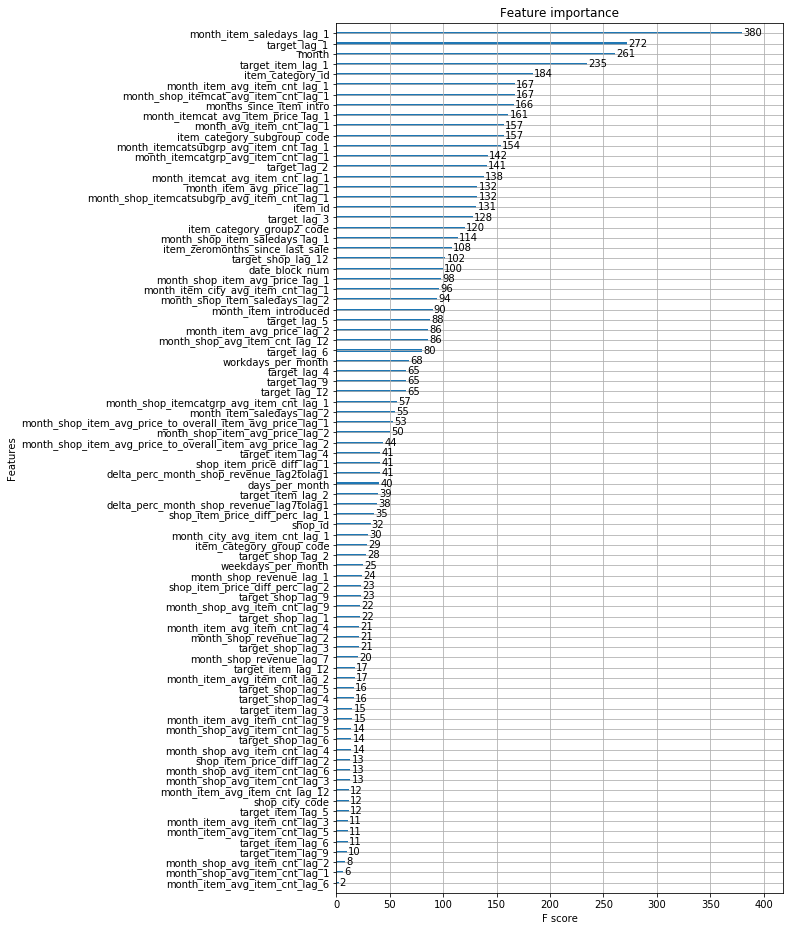

In [45]:
# Check XGB feature importances
fig, ax = plt.subplots(1,1, figsize=(8,16))
plot_importance(xgb_model, ax=ax)

In [21]:
# Try catboost
# Left for later...
#from catboost import CatBoostRegressor  

#cat_features = [0, 1, 3, 4, 5, 6, 7]

#catboost_model = CatBoostRegressor(
#    iterations=500,
#    max_ctr_complexity=4,
#    random_seed=42,
#    od_type='Iter',
#    od_wait=25,
#    verbose=5,
#    depth=4
#)

#catboost_model.fit(
#    X_train, y_train,
#    cat_features=cat_features,
#    eval_set=(X_valid, y_valid)
#)

In [52]:
# fit/load Random forest
# Whether to fit or just load pre-fitted:
USE_SERIALIZED_RF = True

if USE_SERIALIZED_RF:
    print("Loading RF from disk...")   
    rf_model = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-rf_model.pickle'), mode='rb'))
else: # fit
    print("Fitting RF...")
    rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    pickle.dump(rf_model, open(os.path.join(DATA_FOLDER, '2019-03-17-rf_model.pickle'), 'wb'))

    
# Predict
rf_preds_train = rf_model.predict(X_train).clip(0,40)
rf_preds_valid = rf_model.predict(X_valid).clip(0,40)
rf_preds_test = rf_model.predict(X_test).clip(0,40)

pickle.dump(rf_preds_valid, open(os.path.join(DATA_FOLDER, '2019-03-17-rf_preds_valid.pickle'), 'wb'))
pickle.dump(rf_preds_test, open(os.path.join(DATA_FOLDER, '2019-03-17-rf_preds_test.pickle'), 'wb'))

print('Train rmse:', np.sqrt(mean_squared_error(y_train, rf_preds_train)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, rf_preds_valid)))

# Train rmse: 1.0171497932526492
# Validation rmse: 1.1160420489821279

Loading RF from disk...


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning:

overflow encountered in reduce



Train rmse: 1.0171497932526492
Validation rmse: 1.1160420489821279


In [67]:
# Linear regression
# Whether to fit or just load pre-fitted:

# Had overflow issues in the final version. Hence omitted
#LOAD_LR_PREDICTIONS_FROM_DISK = False

#USE_SERIALIZED_LR = False

#if LOAD_LR_PREDICTIONS_FROM_DISK:
#    print("Loading LR predictions from disk...")
#    lr_val_pred = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-lr_preds_valid.pickle'), mode='rb')).clip(0,40)
#    lr_test_pred = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-lr_preds_test.pickle'), mode='rb')).clip(0,40)
#else:
#    # scaling:
#    lr_scaler = MinMaxScaler()
#    lr_scaler.fit(X_train)
#
#    lr_train = lr_scaler.transform(X_train)
#    lr_val = lr_scaler.transform(X_valid)
#    lr_test = lr_scaler.transform(X_test)

#    if USE_SERIALIZED_LR:
#        print("Loading LR from disk...")   
#        lr_model = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-lr_model.pickle'), mode='rb'))
#    else: # fit
#        print("Fitting LR...")
#        lr_model = LinearRegression(n_jobs=-1)
#        lr_model.fit(lr_train, y_train)
#        pickle.dump(lr_model, open(os.path.join(DATA_FOLDER, '2019-03-17-lr_model.pickle'), 'wb'))

#    # Predict
#    lr_train_pred = lr_model.predict(lr_train).clip(0,40)
#    lr_val_pred = lr_model.predict(lr_val).clip(0,40)
#    lr_test_pred = lr_model.predict(lr_test).clip(0,40)

#    # Store predictions:
#    pickle.dump(lr_val_pred, open(os.path.join(DATA_FOLDER, '2019-03-17-lr_preds_valid.pickle'), 'wb'))
#    pickle.dump(lr_test_pred, open(os.path.join(DATA_FOLDER, '2019-03-17-lr_preds_test.pickle'), 'wb'))

#print('Train rmse:', np.sqrt(mean_squared_error(y_train, lr_train_pred)))
#print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, lr_val_pred)))

# When it worked, got:
# Train rmse: 1.1034604043130682
# Validation rmse: 1.1601484470342358

In [ ]:
# Skipped KNN model

#ts = time.time()

#knn_features = ["target_lag_1", "target_lag_2", "target_lag_3", "target_shop_lag_1", "target_shop_lag_1",
#               "target_item_lag_1", "target_item_lag_2", "month_shop_item_saledays_lag_1", "month_item_saledays_lag_1",
#               "month_avg_item_cnt_lag_1", "month_item_avg_item_cnt_lag_1", "month_shop_avg_item_cnt_lag_1",
#               "month_itemcat_avg_item_cnt_lag_1", "month_shop_itemcat_avg_item_cnt_lag_1", "month_itemcatgrp_avg_item_cnt_lag_1",
#               "month_itemcatsubgrp_avg_item_cnt_lag_1", "month_shop_itemcatgrp_avg_item_cnt_lag_1", "month_shop_itemcatsubgrp_avg_item_cnt_lag_1",
#               "item_zeromonths_since_last_sale", "month_item_introduced", "months_since_item_intro"]

# Subsample train set (using the whole data was taking too long).
#X_train_sampled = X_train.sample(1000000, random_state=2)  # toimiiko näin
#Y_train_sampled = y_train.sample(1000000, random_state=2)

#knn_train = X_train_sampled[knn_features]
#knn_val = X_valid[knn_features]
#knn_test = X_test[knn_features]

#knn_scaler = MinMaxScaler()
#knn_scaler.fit(knn_train)
#knn_train = knn_scaler.transform(knn_train)
#knn_val = knn_scaler.transform(knn_val)
#knn_test = knn_scaler.transform(knn_test)

#knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
#knn_model.fit(knn_train, Y_train_sampled)

#knn_train_pred = knn_model.predict(knn_train)
#knn_val_pred = knn_model.predict(knn_val)
#knn_test_pred = knn_model.predict(knn_test)

#print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
#print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, knn_val_pred)))

#time.time() - ts

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int8, float16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [ ]:
# Lets try NN
# Maybe later


In [68]:
# Then use lgbm 
USE_SERIALIZED_LGB = True

if USE_SERIALIZED_LGB:
    print("Loading LGB from disk...") 
    lgb_model = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-lgb_model.pickle'), mode='rb'))
else: #fit
    print("Fitting LGB...") 
    
    lgb_params = {'feature_fraction': 0.75,
                    'metric': 'rmse',
                    'nthread':1,
                    'min_data_in_leaf': 2**7,
                    'bagging_fraction': 0.75,
                    'learning_rate': 0.03,
                    'objective': 'mse',
                    'bagging_seed': 2**7,
                    'num_leaves': 2**7,
                    'bagging_freq':1,
                    'verbose':1
                       }

    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train , label=y_train), 200, \
                      valid_sets=[lgb.Dataset(X_train , label=y_train), lgb.Dataset(X_valid , label=y_valid)],
                     early_stopping_rounds=10)
    
    pickle.dump(lgb_model, open(os.path.join(DATA_FOLDER, '2019-03-17-lgb_model.pickle'), 'wb'))

# Make predictions:
pred_lgb_test = lgb_model.predict(X_test).clip(0,40)
pred_lgb_valid = lgb_model.predict(X_valid).clip(0,40)

print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, pred_lgb_valid)))

# Save predictions
pickle.dump(pred_lgb_valid, open(os.path.join(DATA_FOLDER, '2019-03-17-lgb_preds_valid.pickle'), 'wb'))
pickle.dump(pred_lgb_test, open(os.path.join(DATA_FOLDER, '2019-03-17-lgb_preds_test.pickle'), 'wb'))


Loading LGB from disk...
Validation rmse: 1.0883082703050038


Then lets move ensembling together XGB, RF and LGB.

This mix is suboptimal but there are still model from two (kind of) separate classes. Random forest (bagging) and those boosting tree classifiers.

I'll use just simple linear regression to bundle the predictions together. Train this meta model on the validation dataset and predict the test data. Then finally clip the test data predictions to the given 0,20 range.

Note: this did not beat my best XGB model. So the final submission wasnt this ensemble but the above xgb.

### Ensemble

In [69]:
xgb_preds_valid = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-xgb_preds_valid.pickle'), mode='rb')).clip(0,40)
xgb_preds_test = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-xgb_preds_test.pickle'), mode='rb')).clip(0,40)

rf_preds_valid = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-rf_preds_valid.pickle'), mode='rb')).clip(0,40)
rf_preds_test = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-rf_preds_test.pickle'), mode='rb')).clip(0,40)

#lr_val_pred = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-lr_preds_valid.pickle'), mode='rb')).clip(0,40)
#lr_test_pred = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-lr_preds_test.pickle'), mode='rb')).clip(0,40)

pred_lgb_valid = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-lgb_preds_valid.pickle'), mode='rb')).clip(0,40)
pred_lgb_test = pickle.load(open(os.path.join(DATA_FOLDER, '2019-03-17-lgb_preds_test.pickle'), mode='rb')).clip(0,40)

level1_train = pd.DataFrame(xgb_preds_valid, columns=["xgb"])
level1_train["rf"] = rf_preds_valid
#level1_train["lr"] = lr_val_pred
level1_train["lgb"] = pred_lgb_valid

level1_test = pd.DataFrame(xgb_preds_test, columns=["xgb"])
level1_test["rf"] = rf_preds_test
#level1_test["lr"] = lr_test_pred
level1_test["lgb"] = pred_lgb_test


In [70]:
# Pitäisi näemmä clipata ensin... nuo level1 predictionit...
y_valid.max(), level1_train["xgb"].max(), level1_train["rf"].max(), level1_train["lgb"].max()  #,level1_train["lr"].max(),

(40.0, 40.0, 39.58295472061381, 39.14879485758551)

In [75]:
# Stacker metamodel
stacker_model = LinearRegression(n_jobs=-1)
stacker_model.fit(level1_train, y_valid)  # y_valid is clipped to 0,40 as well

stacker_preds_valid = stacker_model.predict(level1_train)
stacker_preds_test = stacker_model.predict(level1_test)

print('Metamodel train (=valid dataset) rmse:', np.sqrt(mean_squared_error(y_valid, stacker_preds_valid)))  # not proper validation

stacker_subm = pd.DataFrame(index=sales_test.index, data=stacker_preds_test).rename(columns={0:"item_cnt_month"}).reset_index()
print(stacker_subm["item_cnt_month"].sum(), stacker_subm["item_cnt_month"].clip(0,20).sum() )  #
stacker_subm["item_cnt_month"] = stacker_subm["item_cnt_month"].clip(0,20)

stacker_subm.to_csv("2019-03-17-stacker_submission_v2.csv", index=False)

Metamodel train (=valid dataset) rmse: 1.0634334309583144
66112.18584721694 65418.62140681805


In [76]:
# Apply the LB probe also to the stacker test predictions
print("Train set mean of targets: ", my_mean(y_train))
print("Valid set mean of targets: ", my_mean(y_valid))

print("Test set predictions, mean of clipped targets: ", stacker_subm["item_cnt_month"].mean())
print("Preds (clip 0, 40) mean target: ", stacker_preds_test.mean())
# Just doing the maths on this, implied a mean for the target variable in the public leaderboard of 0.28539. Tai 0.2839. 
# Lets say its 0.2839... Scale the predictions and clip again
# Ennusteet näyttävät vähän korkeilta.

stacker_preds_probe_mean_scaled = ((0.2839 / stacker_subm["item_cnt_month"].mean())) * stacker_preds_test
print("Mean of rescaled 0,40 preds: ", stacker_preds_probe_mean_scaled.mean())
stacker_preds_probe_mean_scaled = stacker_preds_probe_mean_scaled.clip(0,20)
print("Mean of rescaled 0,20 preds: ", stacker_preds_probe_mean_scaled.mean())

# Save sub file and try it out
stacker_subm_scaled = pd.DataFrame(index=sales_test.index, data=stacker_preds_probe_mean_scaled).rename(columns={0:"item_cnt_month"}).reset_index()
print(stacker_subm_scaled["item_cnt_month"].sum(), stacker_subm_scaled["item_cnt_month"].clip(0,20).sum() )  #
stacker_subm_scaled["item_cnt_month"] = stacker_subm_scaled["item_cnt_month"].clip(0,20)

stacker_subm_scaled.to_csv("2019-03-17-stacker_probe_rescaled_submission_v2.csv", index=False)


Train set mean of targets:  0.30047606871397203
Valid set mean of targets:  0.27049359286566005
Test set predictions, mean of clipped targets:  0.30540906352388614
Preds (clip 0, 40) mean target:  0.3086469927507794
Mean of rescaled 0,40 preds:  0.28690989137947787
Mean of rescaled 0,20 preds:  0.2843550828372197
60908.85874373246 60908.85874373246


In [77]:
stacker_subm

,ID,item_cnt_month
0,0,0.559960
1,1,0.397606
2,2,1.106264
3,3,0.435410
4,4,3.238261
5,5,0.622804
6,6,0.593739
7,7,0.154304
8,8,0.876243
9,9,0.536795


### Leaderboard probing

#### In the future:

Things to try:

- Different nbr of lags
- Tune model params further
- Onehot vs label enc.
- Months since/to holiday ...
- clipping: at the beginning or in the end (as is now)
- other things to mean encode (or something else than mean...)
- What to do with the new items: better way to handle them
- text based feats
- can we apply matrix factorization
- Could train on valid data after the model is set